#### Generate metrics for IDseq Internal Benchmarks 

Datasets of common clinical microbes and closely-related bacterial species (CCM and CRB) for the idseq-benchmark-manuscript **Supplemental Analysis**.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import json
from collections import Counter

from ete3 import NCBITaxa
ncbi = NCBITaxa()
ncbi.update_taxonomy_database()

%matplotlib inline

Done. Parsing...


Loading node names...
2188555 names loaded.
212927 synonyms loaded.
Loading nodes...
2188555 nodes loaded.
Linking nodes...
Tree is loaded.
Updating database: /Users/katrina.kalantar/.etetoolkit/taxa.sqlite ...
 2188000 generating entries... 
Uploading to /Users/katrina.kalantar/.etetoolkit/taxa.sqlite


Inserting synonyms:      25000 

Inserting taxids:           0   

Inserting taxids:       2185000 

In [2]:
PROJECT = '739'
VERSION = '3.13'

SAMPLE_DICT = {
    '34444':'norg_10__nacc_34__uniform_weight_per_organism__hiseq_reads__v9irreproducible_',
    '34443':'norg_13__nacc_35__uniform_weight_per_organism__hiseq_reads__v10_',
    '34442':'NegControl_LM'    
}

In [3]:
command = "idseq-bench-score "+ PROJECT + " " + '34444' + " " + VERSION
print(command)
bench_result = subprocess.check_output(command, shell=True)
d = json.loads(''.join(bench_result.decode('utf-8').split('\n')[6:]))

idseq-bench-score 739 34444 3.13


### Load Kraken results

In [4]:
kraken_result = pd.read_csv('./data/kraken2/common_microbes/' + SAMPLE_DICT['34444'] + '.kraken2.out', sep='\t', header=None)


In [5]:
kraken_truth = [i.split('.')[1].split('_')[7] for i in kraken_result[1]]
kraken_result['true_sp'] = kraken_truth

# WALK BACK FROM SUBSPECIES
species_values = list(set(kraken_result[2]))
taxid2name = ncbi.get_rank(species_values)
final_species_calls = {}
final_species_calls[0] = 0
for i in taxid2name:
    sp = 0
    if taxid2name[i] == 'subspecies':
        lin = ncbi.get_lineage(i)
        sp = lin[-2]
    elif taxid2name[i] == 'species':
        sp = i
    final_species_calls[i] = sp
kraken_result['species_res'] = [final_species_calls[i] for i in kraken_result[2]]

kraken_result_match = [str(kraken_result.loc[i]['true_sp']) == str(kraken_result.loc[i]['species_res']) for i in range(len(kraken_result.index))]
kraken_result['match'] = kraken_result_match

kraken_result.head()

,0,1,2,3,4,true_sp,species_res,match
0,C,NC_003198.1_0_0__benchmark_lineage_220341_2890...,28901,126|126,1:4 91347:5 1:59 543:7 1:3 590:14 |:| 590:27 2...,28901,28901,True
1,C,NC_003198.1_1_0__benchmark_lineage_220341_2890...,59201,126|126,590:9 543:5 590:13 131567:2 590:23 543:2 590:7...,28901,28901,True
2,C,NC_003198.1_2_0__benchmark_lineage_220341_2890...,590,126|126,590:48 543:5 590:39 |:| 590:59 0:4 543:5 0:7 5...,28901,0,False
3,C,NC_003198.1_3_0__benchmark_lineage_220341_2890...,590,126|126,590:5 0:32 590:35 543:5 590:15 |:| 590:92,28901,0,False
4,C,NC_003198.1_4_0__benchmark_lineage_220341_2890...,90370,126|126,590:2 28901:3 590:5 28901:11 590:29 90370:25 1...,28901,0,False


In [6]:
sp_truth = Counter(kraken_result['true_sp'])

kraken_result['res'] = [str(i) for i in kraken_result[2]]

species_correct = {}
for sp in sp_truth.keys():
    print(sp)
    this_sp = kraken_result[kraken_result['true_sp'] == sp]
    species_correct[sp] = this_sp[this_sp['res'] == sp].shape[0] / this_sp.shape[0]
    
kraken_species_results = pd.Series(species_correct)

28901
548
550
571
573
546
545
562
623
621


In [7]:
ser = pd.Series(Counter(kraken_result['species_res']))
unexpected_sp = [i for i in list(set(kraken_result['species_res'])) if str(i) not in list(set(kraken_result['true_sp'])) + ['0']]
print(ser.shape)
print(ser.loc[unexpected_sp].sum() / kraken_result.shape[0])

(167,)
0.006481814908174289


In [8]:
print("Percentage of Kraken reads that were mapped to something above species level:")
Counter(kraken_result['species_res'])[0] / kraken_result.shape[0]

Percentage of Kraken reads that were mapped to something above species level:


0.7092785980074421

In [9]:
kraken_false_pos_species_count = (len([i for i in list(set(kraken_result['species_res'])) if i not in list(set(kraken_result['true_sp'])) + ['0']]))
print(kraken_false_pos_species_count )

167


### IDseq Recall 

In [10]:
output = {'NT':{}, 'NR':{}}
incorrectly_assigned_reads = {'NT':{}, 'NR':{}}
output_false_pos_species_count = {}

res_nt = d['per_rank']['species']['NT']
for i in res_nt:
    try:
        output['NT'][i] = res_nt[i]['recall_per_read']['value']
    except:
        continue
    try:
        incorrectly_assigned_reads['NT'][i] = res_nt[i]['post_qc_reads'] - res_nt[i]['recall_per_read']['count']
    except:
        continue
        
res_nr = d['per_rank']['species']['NR']
for i in res_nt:
    try:
        output['NR'][i] = res_nr[i]['recall_per_read']['value']
    except:
        continue
    try:
        incorrectly_assigned_reads['NR'][i] = res_nr[i]['post_qc_reads'] - res_nr[i]['recall_per_read']['count']
    except:
        continue
        
idseq_species_results = pd.DataFrame(output)#.plot(kind='bar', width=.75)
incorrectly_assigned_reads_results = pd.DataFrame(incorrectly_assigned_reads)

In [11]:
print("Percentage of READS which are misclassified at the species level:")
incorrectly_assigned_reads_results.sum() / (d['per_rank']['species']['NT']['total_correctly_identified_taxa']*10000)

Percentage of READS which are misclassified at the species level:


NT    0.31776
NR    0.49709
dtype: float64

In [12]:
print("These reads are distributed across a total of N false-positive species-level microbes:")
idseq_NT_false_positive_species_count = (d['per_rank']['species']['NT']['total_identified_taxa'] - d['per_rank']['species']['NT']['total_correctly_identified_taxa'])
print("NT: " + str(idseq_NT_false_positive_species_count))
idseq_NR_false_positive_species_count = (d['per_rank']['species']['NR']['total_identified_taxa'] - d['per_rank']['species']['NR']['total_correctly_identified_taxa'])
print("NR: " + str(idseq_NR_false_positive_species_count))

These reads are distributed across a total of N false-positive species-level microbes:
NT: 83
NR: 371


{545: 'Citrobacter koseri', 546: 'Citrobacter freundii', 548: 'Klebsiella aerogenes', 550: 'Enterobacter cloacae', 562: 'Escherichia coli', 571: 'Klebsiella oxytoca', 573: 'Klebsiella pneumoniae', 621: 'Shigella boydii', 623: 'Shigella flexneri', 28901: 'Salmonella enterica'}


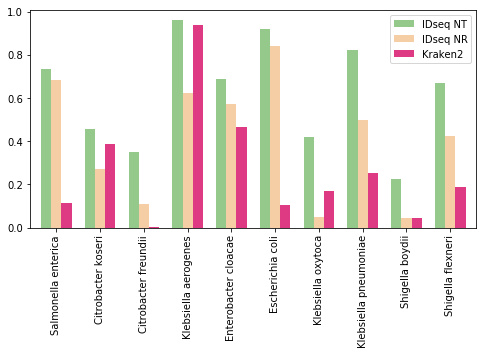

In [13]:
combined_results = pd.concat([idseq_species_results, pd.Series(species_correct).loc[idseq_species_results.index]], axis=1)
combined_results.columns = ['IDseq NT', 'IDseq NR', 'Kraken2']
names = ncbi.get_taxid_translator(list(combined_results.index))
print(names)
new_names = [names[int(i)] for i in combined_results.index]
combined_results.index = new_names

combined_results.plot(kind='bar', width=.7, figsize=(8,4), color=['#94C98B','#F6CEA5','#DD3A83'])

In [14]:
results_described = combined_results.describe()
print(results_described)
print(results_described.loc['50%']['IDseq NT'])
print("IDseq NT, median = " + str(results_described.loc['50%']['IDseq NT']) + ", IQR: " + 
     str(results_described.loc['25%']['IDseq NT']) + " - " + 
      str(results_described.loc['75%']['IDseq NT']))

print("IDseq NR, median = " + str(results_described.loc['50%']['IDseq NR']) + ", IQR: " + 
     str(results_described.loc['25%']['IDseq NR']) + " - " + 
      str(results_described.loc['75%']['IDseq NR']))

print("Kraken2, median = " + str(results_described.loc['50%']['Kraken2']) + ", IQR: " + 
     str(results_described.loc['25%']['Kraken2']) + " - " + 
      str(results_described.loc['75%']['Kraken2']))

import scipy
from scipy import stats
print("is NT significantly different than Kraken2?")
print(scipy.stats.wilcoxon(combined_results['IDseq NT'],combined_results['Kraken2']))

print("is NR significantly different than Kraken2?")
print(scipy.stats.wilcoxon(combined_results['IDseq NR'],combined_results['Kraken2']))

print("is NT significantly different than NR?")
print(scipy.stats.wilcoxon(combined_results['IDseq NR'],combined_results['IDseq NT']))



        IDseq NT   IDseq NR    Kraken2
count  10.000000  10.000000  10.000000
mean    0.623716   0.411078   0.266021
std     0.249476   0.281814   0.276757
min     0.223752   0.043432   0.002200
25%     0.427760   0.148882   0.105911
50%     0.677980   0.461238   0.179137
75%     0.799727   0.608323   0.354025
max     0.958531   0.840541   0.937000
0.6779795408002242
IDseq NT, median = 0.6779795408002242, IQR: 0.4277597972630099 - 0.7997268442747166
IDseq NR, median = 0.461237944821416, IQR: 0.14888232355962377 - 0.6083234386739829
Kraken2, median = 0.1791371794871795, IQR: 0.10591134453781513 - 0.354025150060024
is NT significantly different than Kraken2?
WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)
is NR significantly different than Kraken2?
WilcoxonResult(statistic=17.0, pvalue=0.2845026979112075)
is NT significantly different than NR?
WilcoxonResult(statistic=0.0, pvalue=0.005062032126267864)
